# Introduction to Statistical Mechanics (ME346A)

## 2D Baby Ising Model - Transfer Matrix Method

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm

# import sympy as sp
# from sympy import symbols, exp, simplify, Matrix, log, diff, lambdify, re, Abs

In [ ]:
# Set some global parameters for the model
Nx = 10; Ny = 2 # number of spins in each dimension
n = Nx * Ny # number of total spins

h = 0.0 # external field
J = 1.0 # strength of the spin-spin coupling

kB = 1.0
Tc = 1.5 # critical temperature for 2D Ising with J=1, h=0, k_B=1.
T = 1.0 # initial temperature
beta = 1/T # initial value of beta

In [ ]:
# Transfer matrix
def create_P_numpy(beta, J, h):
    P = np.zeros((4, 4))
    for s1 in [1, -1]:
        for s2 in [1, -1]:
            for s3 in [1, -1]:
                for s4 in [1, -1]:
                    i = int((1-s1) + (1-s2)/2)
                    j = int((1-s3) + (1-s4)/2)
                    minus_eng = (J*s1*s3 + J*s2*s4 +
                                 J/2*s1*s2 + J/2*s3*s4 +
                                 h/2*s1 + h/2*s2 + h/2*s3 + h/2*s4)
                    P[i, j] = np.exp(beta*minus_eng)
    return P

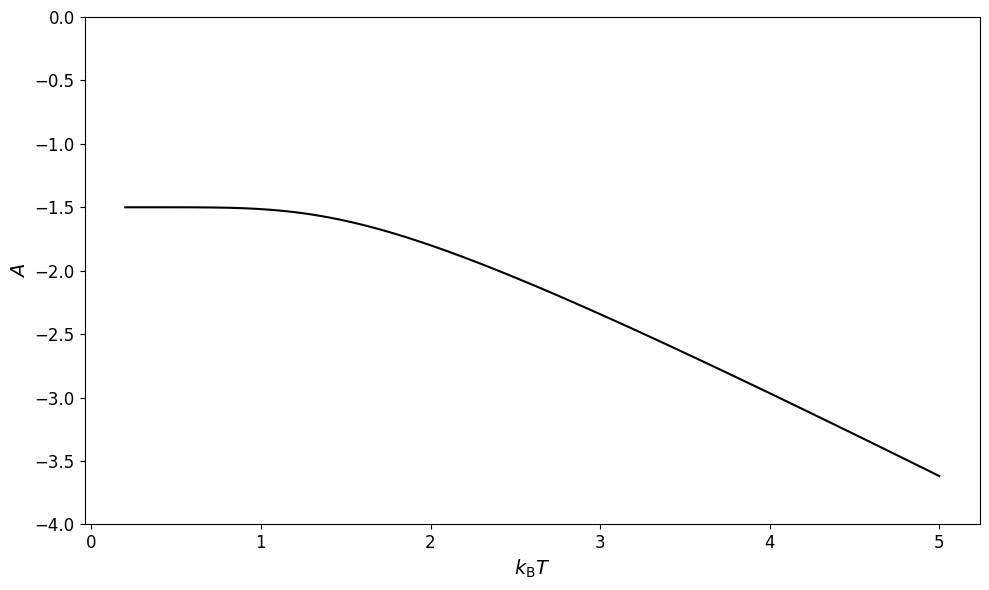

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate Helmholtz free energy
kBT = np.arange(0.2, 5.05, 0.05)
beta_num = 1 / kBT
lambda_num = np.zeros(len(kBT))

for i, beta in enumerate(beta_num):
    P0 = create_P_numpy(beta, 1, 0)
    w = np.linalg.eigvals(P0)
    lambda_num[i] = np.max(np.abs(w))

A_per_spin = -0.5 * kBT * np.log(lambda_num)

plt.figure(figsize=(10, 6))
plt.plot(kBT, A_per_spin, color='black')
plt.xlabel(r'$k_{\rm B} T$', fontsize=14)
plt.ylabel(r'$A$', fontsize=14)
plt.ylim(-4, 0)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()
plt.clf()

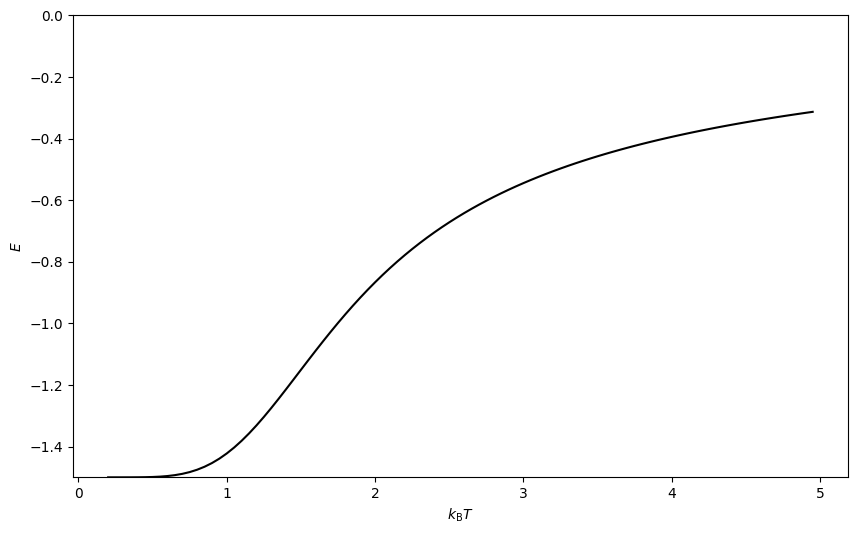

<Figure size 640x480 with 0 Axes>

In [ ]:
# Energy
kBT = np.arange(0.2, 5.05, 0.05)
beta_num = 1 / kBT
lambda_num = np.zeros(len(kBT))

for i, beta in enumerate(beta_num):
    P1 = create_P_numpy(beta, 1, 0)
    w = np.linalg.eigvals(P1)
    lambda_num[i] = np.max(np.abs(w))

dlnlambda = np.diff(np.log(lambda_num))
dbeta = np.diff(beta_num)
dlnlambda_dbeta = dlnlambda / dbeta
E_per_spin = -0.5 * dlnlambda_dbeta

plt.figure(figsize=(10, 6))
plt.plot(kBT[:-1], E_per_spin, color='black')
plt.xlabel(r'$k_{\rm B} T$')
plt.ylabel(r'$E$')
plt.ylim(-1.5, 0)
plt.show()
plt.clf()

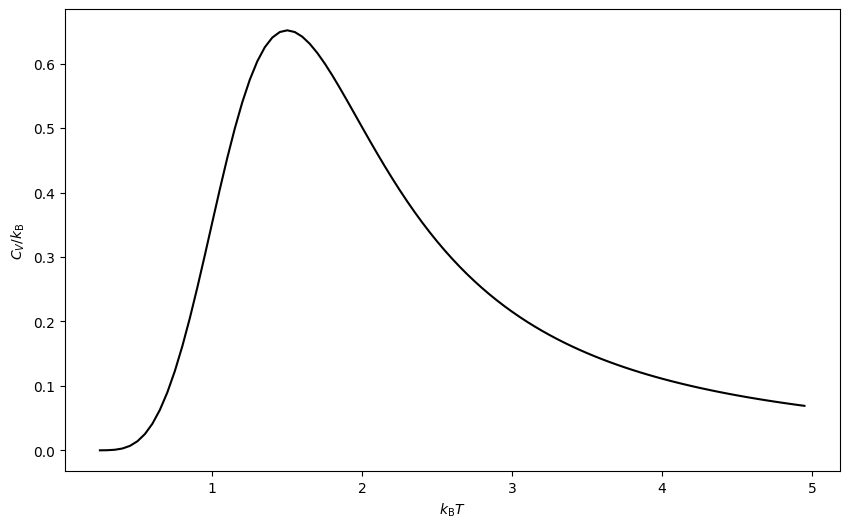

<Figure size 640x480 with 0 Axes>

In [ ]:
# Heat capacity
d2lnlambda = np.diff(dlnlambda_dbeta)
dbeta2 = np.diff(beta_num[1:])
d2lnlambda_dbeta2 = d2lnlambda / dbeta2
cv_per_kB = 0.5 * beta_num[1:-1]**2 * d2lnlambda_dbeta2

plt.figure(figsize=(10, 6))
plt.plot(kBT[1:-1], cv_per_kB, color='black')
plt.xlabel(r'$k_{\rm B} T$')
plt.ylabel(r'$C_V / k_{\rm B}$')
plt.show()
plt.clf()

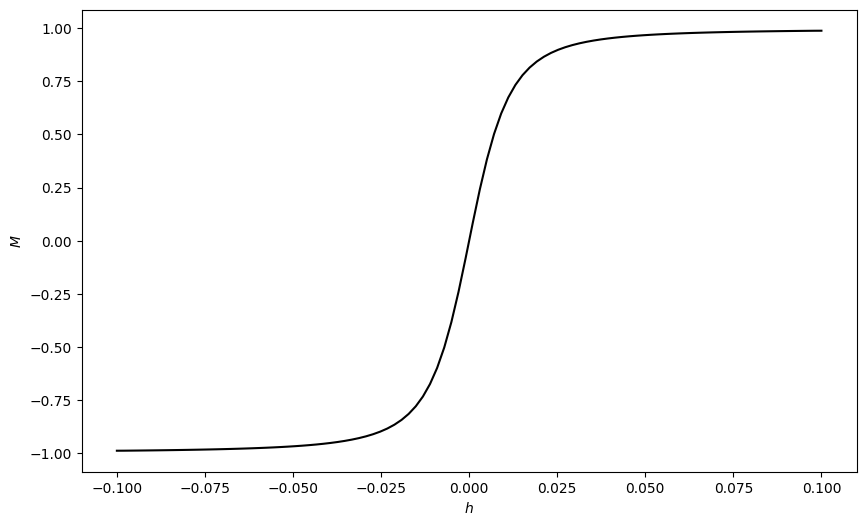

<Figure size 640x480 with 0 Axes>

In [ ]:
# Magnetization
hh = np.linspace(-0.1, 0.1, 100)
lambda_num = np.zeros(len(hh))

for i, h in enumerate(hh):
    P1 = create_P_numpy(1, 1, h)
    w = np.linalg.eigvals(P1)
    lambda_num[i] = np.max(np.abs(w))

dlnlambda_dh = -np.gradient(np.log(lambda_num), hh)
M_per_spin = -0.5 * dlnlambda_dh

plt.figure(figsize=(10, 6))
plt.plot(hh, M_per_spin, color='black')
plt.xlabel(r'$h$')
plt.ylabel(r'$M$')
plt.show()
plt.clf()

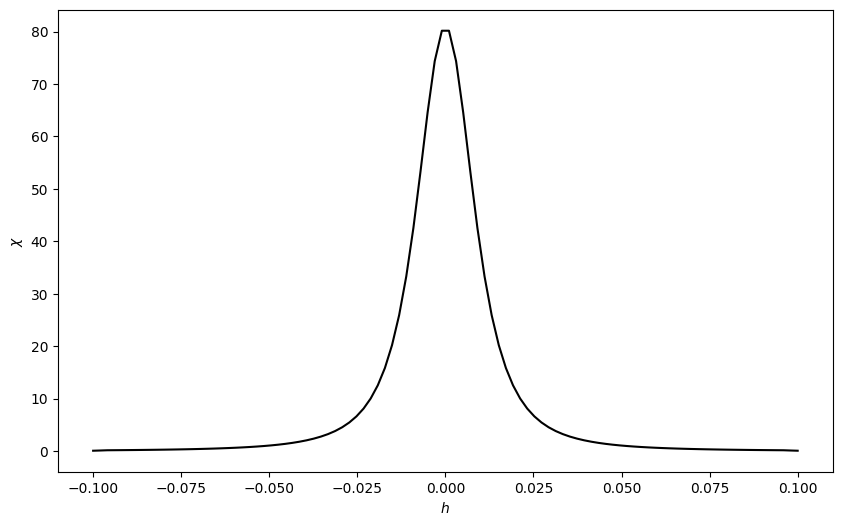

<Figure size 640x480 with 0 Axes>

In [ ]:
# Magnetic susceptibility
dlnlambda_dh = np.gradient(np.log(lambda_num), hh)
d2lnlambda_dh2 = np.gradient(dlnlambda_dh, hh)
Chi_per_spin = 0.5 * d2lnlambda_dh2

plt.figure(figsize=(10, 6))
plt.plot(hh, Chi_per_spin, color='black')
plt.xlabel(r'$h$')
plt.ylabel(r'$\chi$')
plt.show()
plt.clf()

## 2D Baby Ising Model - Monte Carlo

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
np.random.seed(2025)

In [ ]:
# Set some global parameters for the model
Nx = 10; Ny = 2 # number of spins in each dimension
n = Nx * Ny # number of total spins

h = 0.0 # external field
J = 1.0 # strength of the spin-spin coupling

kB = 1.0
Tc = 1.5 # critical temperature for 2D Ising with J=1, h=0, k_B=1.
T = 1.0 # initial temperature
beta = 1/(kB * T) # initial value of beta

In [ ]:
def init_lattice(Nx, Ny):
    return 2 * np.random.randint(2, size=(Ny, Nx)) - 1

def draw_lattice(lattice_conf):
    plt.imshow(lattice_conf)

In [ ]:
def neighsum(conf, i, j):
    neighsum = 0.0
    if i < Ny - 1: neighsum += conf[i+1, j]
    if i > 0: neighsum += conf[i-1, j]
    neighsum += conf[i,(j+1)%Nx]
    neighsum += conf[i,(j-1)%Nx]
    return neighsum

def calc_e(conf):
    energy = 0.
    for i in range(Ny):
        for j in range(Nx):
            energy += -h * conf[i,j]
            energy += -0.5 * J * neighsum(conf,i,j) * conf[i,j] # factor of 2 because the pair i,j is visited twice in the loop
    return energy

In [ ]:
def calc_de(conf, i, j):
    delta_energy = 0.0
    delta_energy += -h * (-conf[i,j] - conf[i,j])
    delta_energy += -1.0 * J * neighsum(conf,i,j) * (-conf[i,j] - conf[i,j])
    return delta_energy

In [ ]:
def mc_step(conf, beta):
    i = np.random.randint(Ny)
    j = np.random.randint(Nx)
    delta_e = calc_de(conf,i,j)
    prob_acc = np.min([1.0, np.exp(-beta * delta_e)])
    if np.random.rand() < prob_acc:
        conf[i,j] *= -1
        return conf
    else:
        return conf

In [ ]:
def run_mc(conf, beta):
    for attempt in range(n):
        conf = mc_step(conf, beta)
    return conf

In [ ]:
def run_traj(conf, n_itrs, beta):
    traj = np.zeros([n_itrs, Ny, Nx], dtype=int)
    for itr in tqdm(range(n_itrs), desc='MC'):
        conf = run_mc(conf, beta)
        traj[itr] = conf
    return traj

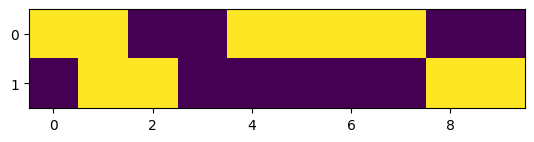

In [ ]:
# Generate initial configuration
conf = init_lattice(Nx, Ny)
draw_lattice(conf)

In [ ]:
# Run Ising model
n_sweeps = 10000
traj = run_traj(conf, n_sweeps, beta)

MC: 100%|██████████| 10000/10000 [00:05<00:00, 1731.13it/s]


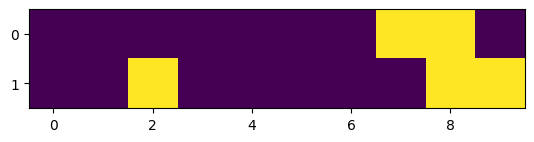

In [ ]:
# Visualize the trajectory
plot_traj = traj[::100, :, :]

fig = plt.figure()
ax = plt.gca()

im = ax.imshow(plot_traj[0]) # set initial display dimensions

def animate_func(i):
    im.set_array(plot_traj[i])
    return [im]

ani = FuncAnimation(fig, animate_func, frames=len(plot_traj), cache_frame_data=False)
ani.save('ising.gif', writer='pillow', fps=10)

In [ ]:
def compute_running_m(traj, burn_in=0):
    traj_cut = traj[burn_in:]
    cumulative_sum = np.cumsum(np.mean(traj_cut, axis=(1,2)))
    running_mean = cumulative_sum / np.arange(1, len(traj_cut) + 1)
    return running_mean

def calc_m(traj, burn_in=1000):
    traj_cut = traj[burn_in:, ...]
    mean = np.mean(traj_cut)
    return mean

def calc_var_m(traj, burn_in=1000):
    traj_cut = traj[burn_in:, ...]
    var = np.var(traj_cut)
    return var

def calc_avg_e(traj, burn_in=1000):
    traj_cut = traj[burn_in:, ...]
    avg_e = 0.0
    for j in range(traj_cut.shape[0]):
        avg_e += calc_e(traj_cut[j, ...])
    return avg_e / traj_cut.shape[0]

def calc_var_e(traj, burn_in=1000):
    avg_e = calc_avg_e(traj=traj, burn_in=burn_in)
    traj_cut = traj[burn_in:, ...]
    var_e = 0.0
    for j in range(traj_cut.shape[0]):
        var_e += (calc_e(traj_cut[j, ...]) - avg_e)**2
    return var_e / traj_cut.shape[0]

In [ ]:
# Compute the average of <M> for h in the range(-0.5, 0.5)
T = 1.0
beta = 1/T
n_ticks = 10

hs = np.linspace(-0.5, 0.5, n_ticks)
ms = np.zeros(n_ticks)
var_ms = np.zeros(n_ticks)

for i, h_field in enumerate(hs):
    h = h_field
    conf = init_lattice(Nx, Ny) # important to reinitialize
    traj = run_traj(conf, 5000, beta)
    ms[i] = calc_m(traj)
    var_ms[i] = calc_var_m(traj)

MC: 100%|██████████| 5000/5000 [00:03<00:00, 1484.67it/s]


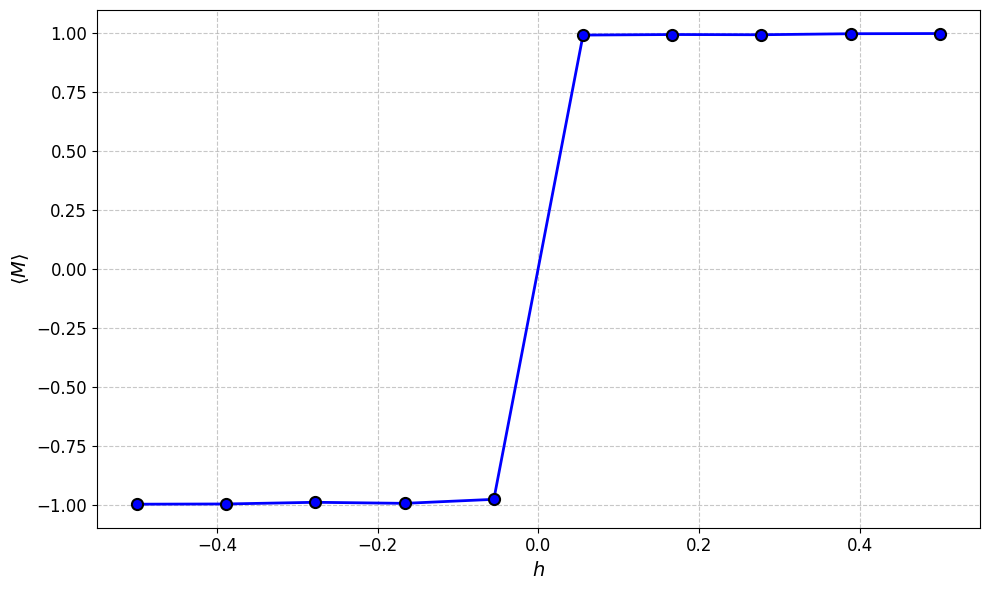

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot relation between <M> and h
plt.figure(figsize=(10, 6))
plt.plot(hs, ms, 'o-', color='blue', markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=1.5)
plt.xlabel(r'$h$', fontsize=14)
plt.ylabel(r'$\langle M \rangle$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(-0.55, 0.55)
plt.tight_layout()
plt.show()
plt.clf()

In [ ]:
# No external field: make sure to set h=0
h=0.0
n_ticks = 30

Ts = np.linspace(1.0, 3.0, n_ticks)
es = np.zeros(n_ticks)
var_es = np.zeros(n_ticks)

for i, Temp in enumerate(Ts):
    T = Temp
    conf = init_lattice(Nx, Ny)
    traj = run_traj(conf, 5000, 1/T)
    es[i] = calc_avg_e(traj) / (Nx * Ny)
    var_es[i] = calc_var_e(traj) / (Nx * Ny)

MC: 100%|██████████| 5000/5000 [00:02<00:00, 1849.12it/s]


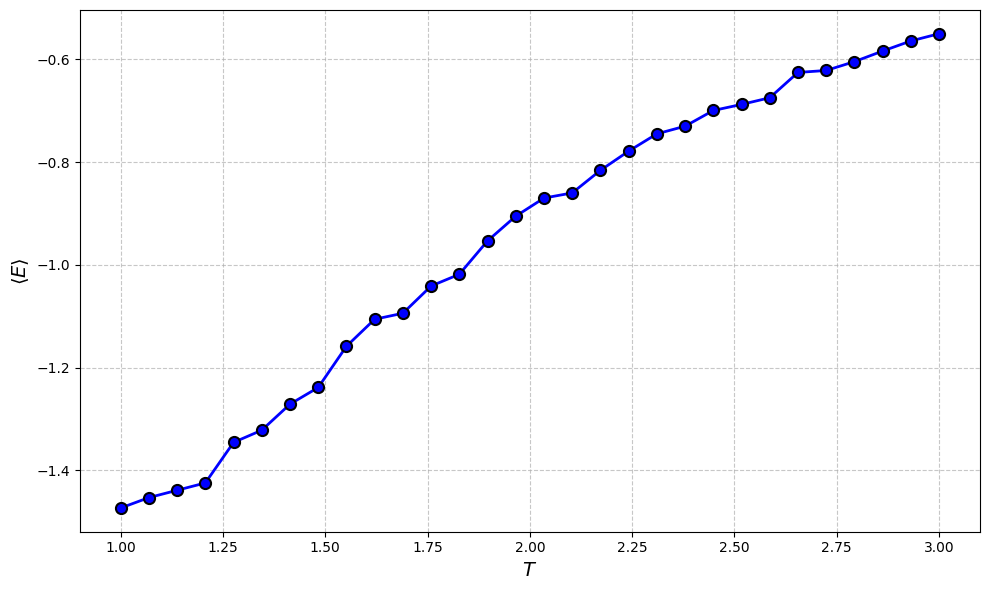

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the relation between E and T
plt.figure(figsize=(10, 6))
plt.plot(Ts, es, 'o-', color='blue', markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=1.5)
plt.xlabel(r'$T$', fontsize=14)
plt.ylabel(r'$\langle E \rangle$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(Ts[0] - 0.1, Ts[-1] + 0.1)
plt.tight_layout()
plt.show()
plt.clf()

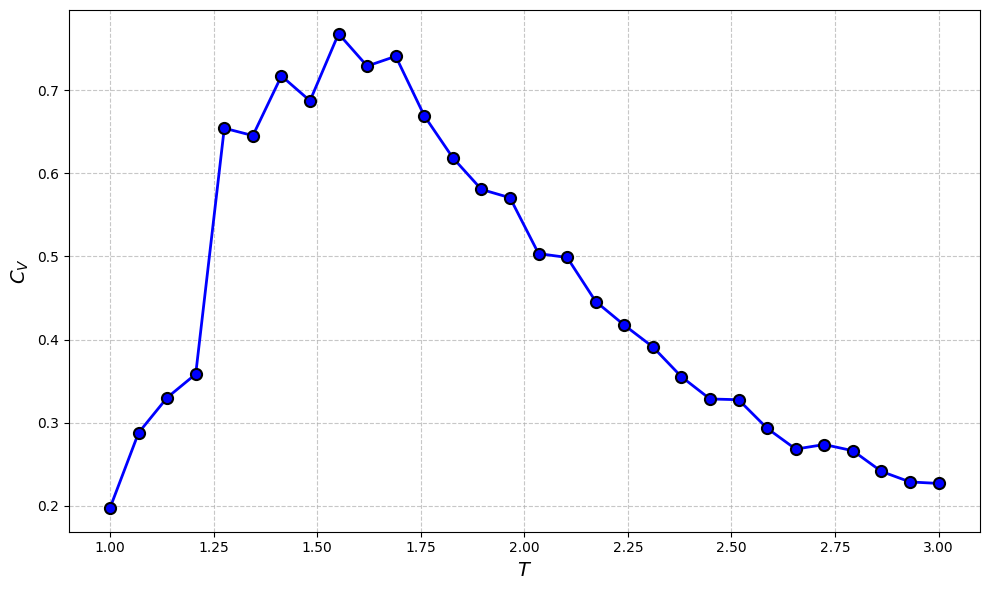

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the relation between C_V and T
cv = var_es / Ts**2
plt.figure(figsize=(10, 6))
plt.plot(Ts, cv, 'o-', color='blue', markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=1.5)
plt.xlabel(r'$T$', fontsize=14)
plt.ylabel(r'$C_V$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(Ts[0] - 0.1, Ts[-1] + 0.1)
plt.tight_layout()
plt.show()
plt.clf()

## Comparison

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

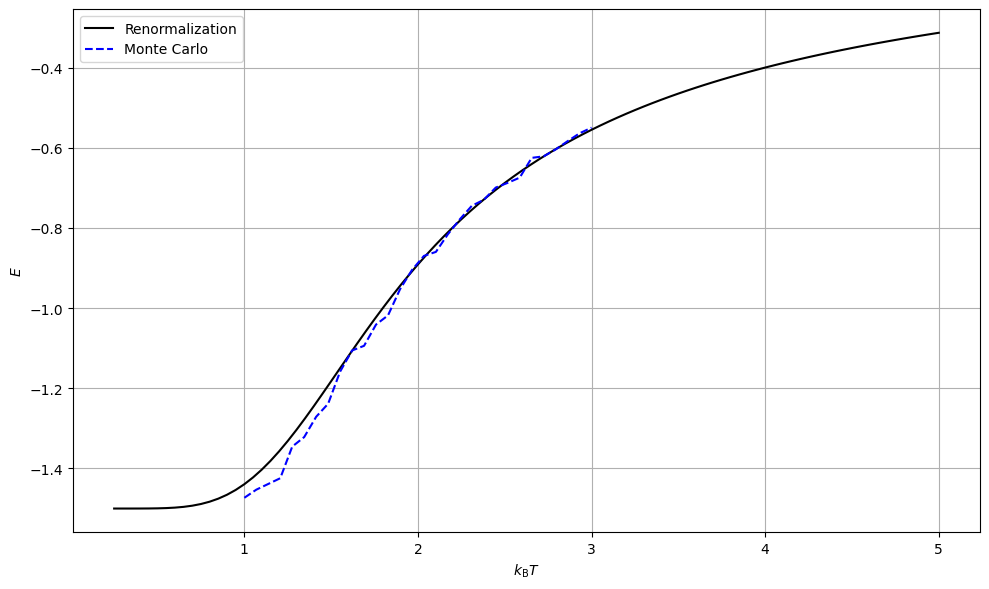

In [ ]:
# Compare energy
plt.figure(figsize=(10, 6))
plt.plot(kBT[1:], E_per_spin, color='black', label='Renormalization')
plt.plot(Ts, es, color='blue', linestyle='--', label='Monte Carlo')
plt.xlabel(r'$k_{\rm B}T$')
plt.ylabel(r'$E$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

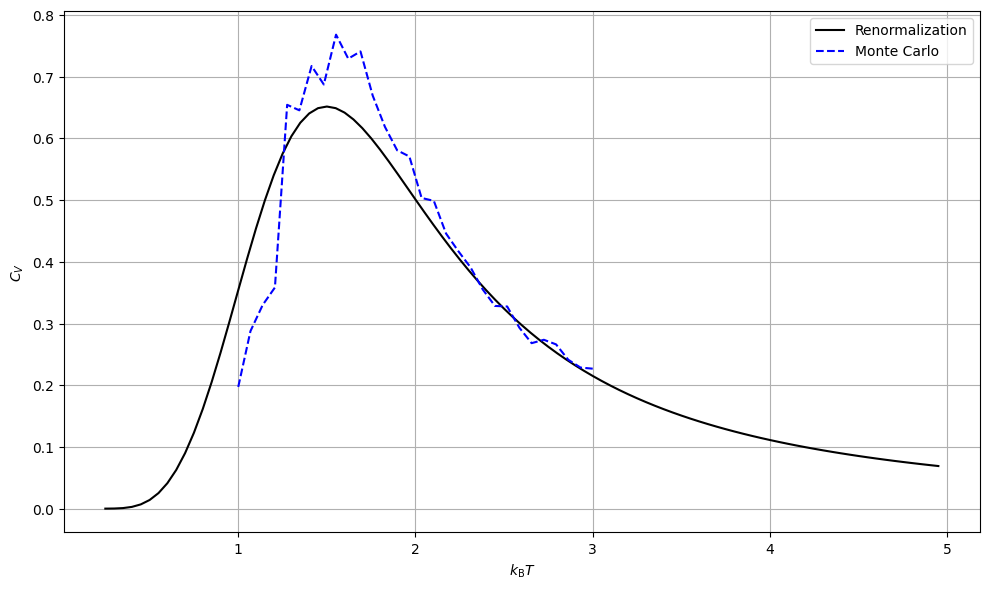

In [ ]:
# Compare heat capacity
plt.figure(figsize=(10, 6))
plt.plot(kBT[1:-1], cv_per_kB, color='black', label='Renormalization')
plt.plot(Ts, cv, color='blue', linestyle='--', label='Monte Carlo')
plt.xlabel(r'$k_{\rm B}T$')
plt.ylabel(r'$C_V$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

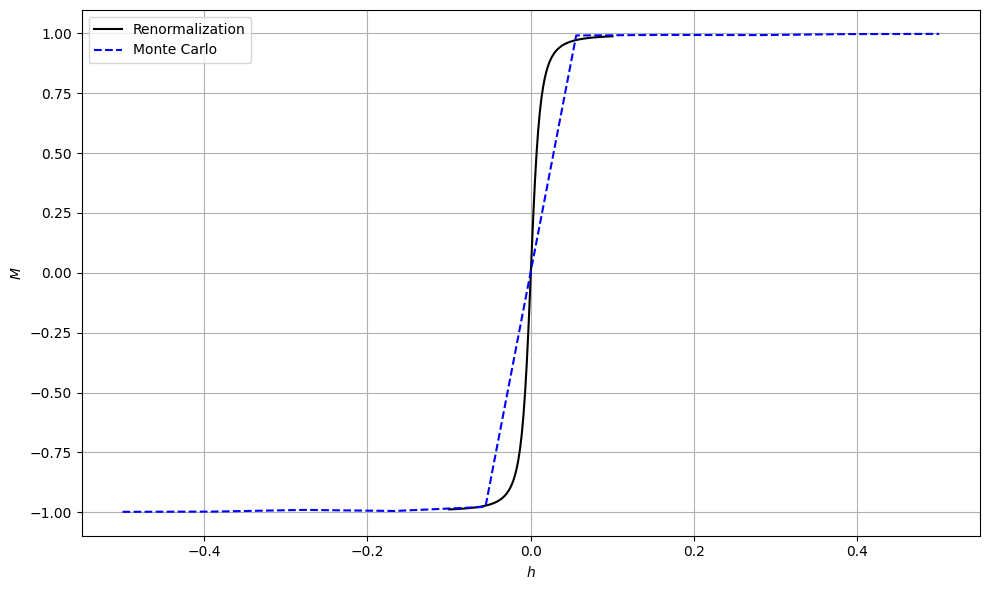

In [ ]:
# Compare magnetization
plt.figure(figsize=(10, 6))
plt.plot(hh, M_per_spin, color='black', label='Renormalization')
plt.plot(hs, ms, color='blue', linestyle='--', label='Monte Carlo')
plt.xlabel(r'$h$')
plt.ylabel(r'$M$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Appendix

In [ ]:
# Plot the running average of <M> after equilibrating
running_m_burn100 = compute_running_m(traj, burn_in=100)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(100, len(running_m)), running_m_burn100, color='blue', linewidth=2)

# plt.title('Running Average <M> vs Number of Samples', fontsize=16, fontweight='bold')
plt.xlabel('Trajectory Time', fontsize=12)
plt.ylabel(r'Running Average $<M>$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()
plt.clf()

NameError: name 'running_m' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot the running average <M> as a function of the number of samples
running_m = compute_running_m(traj, burn_in=0)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(running_m)), running_m, color='blue', linewidth=2)

# plt.title('Running Average <M> vs Number of Samples', fontsize=16, fontweight='bold')
plt.xlabel('Trajectory Time', fontsize=12)
plt.ylabel(r'Running Average $<M>$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()
plt.clf()

In [ ]:
# Generate transfer matrix
beta, J, h = symbols('beta J h')

P = Matrix(4, 4, lambda i, j: 0)
for s1 in [1, -1]:
    for s2 in [1, -1]:
        for s3 in [1, -1]:
            for s4 in [1, -1]:
                i = int((1-s1) + (1-s2)/2)
                j = int((1-s3) + (1-s4)/2)
                minus_eng = (J*s1*s3 + J*s2*s4 +
                             J/2*s1*s2 + J/2*s3*s4 +
                             h/2*s1 + h/2*s2 + h/2*s3 + h/2*s4)
                P[i, j] = exp(beta*minus_eng)

print(P)

In [ ]:
# Calculate eigenvalues
P0 = simplify(P.subs({h: 0, J: 1}))
lambda_sym = list(P0.eigenvals().keys())

kBT = np.arange(0.2, 5.05, 0.05)
beta_num = 1 / kBT

lambda_num = np.zeros((len(kBT), 4))
for i, b in enumerate(beta_num):
    lambda_num[i, :] = [float(l.subs(beta, b)) for l in lambda_sym]

max_lambda = np.max(lambda_num, axis=1)
A_per_spin = -0.5 * kBT * np.log(max_lambda)

plt.figure(figsize=(10, 6))
plt.plot(kBT, A_per_spin, color='black')
plt.xlabel(r'$k_{\rm B} T$')
plt.ylabel(r'$A$')
plt.ylim(-4, 0)
plt.show()
plt.clf()

In [ ]:
# Plot relation between \chi and h
chi = beta * var_ms
plt.figure(figsize=(10, 6))
plt.plot(hs, chi, 'o-', color='blue', markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=1.5)
plt.xlabel(r'$h$', fontsize=14)
plt.ylabel(r'$\chi$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(-0.55, 0.55)
plt.tight_layout()
plt.show()
plt.clf()